# 觀察大局
- 業務目標
    - 預測台北市房屋總房價
    - 專注在住宅方面
- 機器學習問題分類
    - 監督式回歸問題
- 評分方式
    - hit-rate
- 基本假設
    - 與地坪、建坪、地區、建材、屋齡、學區、平均房間數有關

# 獲取資料
- 內政部「不動產交易實價登錄」提供的不動產買賣資料集

# 研究資料
- 利用dataframe操作副本, 維持原始資料乾淨
- 研究每個特徵
    - 缺失值百分比
    - 噪音
    - 分布類型
- 資料視覺化幫助觀察資料有無異狀
    - 相關係數(注意, 只觀察得到線性關係)
        - 熱力圖
        - scatter-matrix
    - 資料分布
        - 直方圖
        - 散步圖

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# 讀取原始資料

data = pd.read_csv('105-108o.csv')[1:]   # 第一筆為英文欄位名稱, 直接去掉

In [2]:
# 先稍微看一下原始資料, 查看資料型態、數值等等
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81165 entries, 1 to 81165
Data columns (total 28 columns):
鄉鎮市區            81165 non-null object
交易標的            81165 non-null object
土地區段位置建物區段門牌    81165 non-null object
土地移轉總面積平方公尺     81165 non-null object
都市土地使用分區        80347 non-null object
非都市土地使用分區       25 non-null object
非都市土地使用編定       14 non-null object
交易年月日           81165 non-null object
交易筆棟數           81165 non-null object
移轉層次            72868 non-null object
總樓層數            72757 non-null object
建物型態            81165 non-null object
主要用途            70619 non-null object
主要建材            72921 non-null object
建築完成年月          64870 non-null object
建物移轉總面積平方公尺     81165 non-null object
建物現況格局.房        81165 non-null object
建物現況格局.廳        81165 non-null object
建物現況格局.衛        81165 non-null object
建物現況格局.隔間       81165 non-null object
有無管理組織          81165 non-null object
總價元             81165 non-null object
單價元平方公尺         76271 non-null object
車位類別            28450 n

In [3]:
# 原始資料的資料分布概略情形, 可以知道因為太多非數值, 必須要轉換後才能看清
data.describe()

,鄉鎮市區,交易標的,土地區段位置建物區段門牌,土地移轉總面積平方公尺,都市土地使用分區,非都市土地使用分區,非都市土地使用編定,交易年月日,交易筆棟數,移轉層次,...,建物現況格局.衛,建物現況格局.隔間,有無管理組織,總價元,單價元平方公尺,車位類別,車位移轉總面積平方公尺,車位總價元,備註,編號
count,81165,81165,81165,81165,80347,25,14,81165,81165,72868,...,81165,81165,81165,81165,76271,28450,81165,81165,38625,81165
unique,13,6,15345,9963,6,2,1,2554,389,443,...,31,3,3,13191,61801,8,4940,789,6035,81152
top,中山區,房地(土地+建物),臺北市萬華區康定路91~120號,0.0,住,the non-metropolis land use district,non-metropolis land use,1050516,土地1建物1車位0,四層,...,1,有,有,12000000,0,坡道平面,0.0,0,含增建或未登記建物。,serial number
freq,11053,44860,747,842,46403,14,14,497,31561,8314,...,28702,73702,46069,765,665,20465,60039,65697,10309,14


In [4]:
# 接著看一下缺失值比例

def miss(x):
    return sum(pd.isnull(x)) / len(x)

miss_result = dict()

for column in data.columns:
    miss_result[column] = miss(data[column])

# 排序一下, 看比較清楚

miss_result = sorted(miss_result.items(), key=lambda s: s[1], reverse=True)  # 使用sorted, 然後用缺失比例來排序, 與就是s[1]
miss_result

[('非都市土地使用編定', 0.9998275118585597),
 ('非都市土地使用分區', 0.9996919854617138),
 ('車位類別', 0.6494794554302963),
 ('備註', 0.52411753834781),
 ('建築完成年月', 0.2007638760549498),
 ('主要用途', 0.12993285283065362),
 ('總樓層數', 0.10359144951641718),
 ('移轉層次', 0.10222386496642641),
 ('主要建材', 0.10157087414525966),
 ('單價元平方公尺', 0.0602969260149079),
 ('都市土地使用分區', 0.010078235692724697),
 ('鄉鎮市區', 0.0),
 ('交易標的', 0.0),
 ('土地區段位置建物區段門牌', 0.0),
 ('土地移轉總面積平方公尺', 0.0),
 ('交易年月日', 0.0),
 ('交易筆棟數', 0.0),
 ('建物型態', 0.0),
 ('建物移轉總面積平方公尺', 0.0),
 ('建物現況格局.房', 0.0),
 ('建物現況格局.廳', 0.0),
 ('建物現況格局.衛', 0.0),
 ('建物現況格局.隔間', 0.0),
 ('有無管理組織', 0.0),
 ('總價元', 0.0),
 ('車位移轉總面積平方公尺', 0.0),
 ('車位總價元', 0.0),
 ('編號', 0.0)]

# 準備數據、前處理
- 測試集20%
- 資料清理
    - 修復或者刪除異常值
    - 填補缺失值或者刪除該筆資料
- 特徵選擇
    - 刪除不能為目標提供有效訊息的特徵
- 資料轉換
    - 轉化為數值
    - 分解特徵
        - 如日期切成年、季
    - 特徵轉換

# 下面的兩個block是R code
## 專注於前處理

In [ ]:
library(tibble)
library(stringr)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

a = read.csv("../../data/106-1/A_lvr_land_A.csv", stringsAsFactors=FALSE)
b = read.csv("../../data/106-2/A_lvr_land_A.csv", stringsAsFactors=FALSE)
c = read.csv("../../data/106-3/A_lvr_land_A.csv", stringsAsFactors=FALSE)
d = read.csv("../../data/106-4/A_lvr_land_A.csv", stringsAsFactors=FALSE)
e = read.csv("../../data/107-1/台北市不動產買賣.csv", stringsAsFactors=FALSE)
f = read.csv("../../data/107-2/A_lvr_land_A.csv", stringsAsFactors=FALSE)
g = read.csv("../../data/107-3/A_lvr_land_A.csv", stringsAsFactors=FALSE)
h = read.csv("../../data/107-4/A_lvr_land_A.csv", stringsAsFactors=FALSE)
i = read.csv("../../data/108-1/A_lvr_land_A.csv", stringsAsFactors=FALSE)
j = read.csv("../../data/108-2/A_lvr_land_A.csv", stringsAsFactors=FALSE)
k = read.csv("../../data/108-3/A_lvr_land_A.csv", stringsAsFactors=FALSE)
l = read.csv("../../data/105-1/A_lvr_land_A.csv", stringsAsFactors=FALSE)
m = read.csv("../../data/105-2/A_lvr_land_A.csv", stringsAsFactors=FALSE)
n = read.csv("../../data/105-3/A_lvr_land_A.csv", stringsAsFactors=FALSE)
o = read.csv("../../data/105-4/A_lvr_land_A.csv", stringsAsFactors=FALSE)

x = rbind(a,b)
x = rbind(x,c)
x = rbind(x,d)
x = rbind(x,e)
x = rbind(x,f)
x = rbind(x,g)
x = rbind(x,h)
x = rbind(x,i)
x = rbind(x,j)
x = rbind(x,k)
x = rbind(x,l)
x = rbind(x,m)
x = rbind(x,n)
x = rbind(x,o)

names(x)[names(x) == "建物現況格局-房"] = "建物現況格局.房"
names(x)[names(x) == "建物現況格局-廳"] = "建物現況格局.廳"
names(x)[names(x) == "建物現況格局-衛"] = "建物現況格局.衛"
names(x)[names(x) == "建物現況格局-隔間"] = "建物現況格局.隔間"

# 去除標題
x = x[-1,]
#x = x[-1,]

title = c("鄉鎮市區", "交易標的", "土地移轉總面積平方公尺", "都市土地使用分區", "交易年月日", "移轉層次", "總樓層數", "建物型態", 
"主要用途", "屋齡", "坪數", "建物現況格局-房", "建物現況格局-廳", "建物現況格局-衛", "建物現況格局-隔間", "有無管理組織", 
"總價", "單價元", "車位坪數", "車位總價格")

#市區編號 1
x$鄉鎮市區[x$鄉鎮市區=="士林區"] = 0
x$鄉鎮市區[x$鄉鎮市區=="大同區"] = 1
x$鄉鎮市區[x$鄉鎮市區=="大安區"] = 2
x$鄉鎮市區[x$鄉鎮市區=="中山區"] = 3
x$鄉鎮市區[x$鄉鎮市區=="中正區"] = 4
x$鄉鎮市區[x$鄉鎮市區=="內湖區"] = 5
x$鄉鎮市區[x$鄉鎮市區=="文山區"] = 6
x$鄉鎮市區[x$鄉鎮市區=="北投區"] = 7
x$鄉鎮市區[x$鄉鎮市區=="松山區"] = 8
x$鄉鎮市區[x$鄉鎮市區=="信義區"] = 9
x$鄉鎮市區[x$鄉鎮市區=="南港區"] = 10
x$鄉鎮市區[x$鄉鎮市區=="萬華區"] = 11
x$鄉鎮市區 = as.integer(x$鄉鎮市區)

#$交易標的 2
x$交易標的[x$交易標的=="房地(土地+建物)+車位"] = 0
x$交易標的[x$交易標的=="房地(土地+建物)"] = 1
x$交易標的[x$交易標的=="建物"] = 2
x = subset(x, x$交易標的 != "車位")
x = subset(x, x$交易標的 != "土地")

#去掉門牌
x = x[,-3]

#保留土地移轉總面積平方公尺 3

#分區使用 4
x$都市土地使用分區[x$都市土地使用分區=="住"] = 0
x$都市土地使用分區[x$都市土地使用分區=="商"] = 1
x$都市土地使用分區[x$都市土地使用分區=="工"] = 2
x$都市土地使用分區[x$都市土地使用分區=="其他"] = 3
x = subset(x, x$都市土地使用分區 != "")

#去掉無資料的欄位
x = x[,-5]
x = x[,-5]

#交易年月日 最後

#去掉交易筆棟數
x = x[,-6]
#移轉層次 


#處理總層數 7
x$總樓層數 = gsub("層","",x$總樓層數)

#X
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1)=="一" ] = 1
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1)=="二" ] = 2
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1)=="三" ] = 3
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1)=="四" ] = 4
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1)=="五" ] = 5
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1)=="六" ] = 6
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1)=="七" ] = 7
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1)=="八" ] = 8
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1)=="九" ] = 9
x$總樓層數[nchar(x$總樓層數) == 1 & substr(x$總樓層數,1,1) == "十" ] = 10

#1X

x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="十" & substr(x$總樓層數,2,2) == "一"] = 11
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="十" & substr(x$總樓層數,2,2) == "二"] = 12
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="十" & substr(x$總樓層數,2,2) == "三"] = 13
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="十" & substr(x$總樓層數,2,2) == "四"] = 14
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="十" & substr(x$總樓層數,2,2) == "五"] = 15
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="十" & substr(x$總樓層數,2,2) == "六"] = 16
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="十" & substr(x$總樓層數,2,2) == "七"] = 17
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="十" & substr(x$總樓層數,2,2) == "八"] = 18
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="十" & substr(x$總樓層數,2,2) == "九"] = 19
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,2,2) == "十"] = 20
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,2,2) == "十"] = 30
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,2,2) == "十"] = 40
x$總樓層數[nchar(x$總樓層數) == 2 & substr(x$總樓層數,1,1)=="五" & substr(x$總樓層數,2,2) == "十"] = 50

#2X

x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,3,3) == "一"] = 21
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,3,3) == "二"] = 22
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,3,3) == "三"] = 23
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,3,3) == "四"] = 24
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,3,3) == "五"] = 25
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,3,3) == "六"] = 26
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,3,3) == "七"] = 27
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,3,3) == "八"] = 28
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="二" & substr(x$總樓層數,3,3) == "九"] = 29

#3X

x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,3,3) == "一"] = 31
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,3,3) == "二"] = 32
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,3,3) == "三"] = 33
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,3,3) == "四"] = 34
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,3,3) == "五"] = 35
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,3,3) == "六"] = 36
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,3,3) == "七"] = 37
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,3,3) == "八"] = 38
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="三" & substr(x$總樓層數,3,3) == "九"] = 39

#4X

x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,3,3) == "ㄧ"] = 41
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,3,3) == "二"] = 42
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,3,3) == "三"] = 43
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,3,3) == "四"] = 44
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,3,3) == "五"] = 45
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,3,3) == "六"] = 46
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,3,3) == "七"] = 47
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,3,3) == "八"] = 48
x$總樓層數[nchar(x$總樓層數) == 3 & substr(x$總樓層數,1,1)=="四" & substr(x$總樓層數,3,3) == "九"] = 49

#處理建物型態 8
x = subset(x,x$建物型態 != "倉庫")   #刪除建物型態 = 倉庫
x = subset(x,x$建物型態 != "廠辦")
x = subset(x,x$建物型態 != "店面(店鋪)")
x = subset(x,x$建物型態 != "工廠")
x = subset(x,x$建物型態 != "其他")
x$建物型態[x$建物型態 == "辦公商業大樓"] = 0
x$建物型態[x$建物型態 == "公寓(5樓含以下無電梯)"] = 1
x$建物型態[x$建物型態 == "華廈(10層含以下有電梯)"] = 2
x$建物型態[x$建物型態 == "套房(1房1廳1衛)"] = 3
x$建物型態[x$建物型態 == "住宅大樓(11層含以上有電梯)"] = 4
x$建物型態[x$建物型態 == "透天厝"] = 5
x$主要用途 = as.integer(x$建物型態)

#處理主要用途 9
x = subset(x,x$主要用途 != "商業用")  #刪除主要用途 = 商業
x = subset(x,x$主要用途 != "工業用")
x = subset(x,x$主要用途 != "見其他登記事項")
x$主要用途[x$主要用途=="住家用"] = 0
x$主要用途[x$主要用途=="住商用"] = 1
x$主要用途[x$主要用途=="住工用"] = 2
x$主要用途[x$主要用途=="國民住宅"] = 3
x$主要用途[x$主要用途=="停車空間"] = 4
x$主要用途[x$主要用途=="見使用執照"] = 5
tmp = getmode(x$主要用途)
x$主要用途[x$主要用途 == ""] = tmp
x$主要用途 = as.integer(x$主要用途)

#處理主要建材
x = x[,-10]

#處理建築完成年月 屋齡 缺值填區的平均值
x$建築完成年月 = as.integer(x$建築完成年月)
x = subset(x,x$建築完成年月 != 5701)
x$建築完成年月 = round(x$建築完成年月/10000)
x$建築完成年月 =  (109 - x$建築完成年月) #計算屋齡

c0 = c()
c1 = c()
c2 = c()
c3 = c()
c4 = c()
c5 = c()
c6 = c()
c7 = c()
c8 = c()
c9 = c()
c10 = c()
c11 = c()
for(i in 1:nrow(x)){
  if(x$鄉鎮市區[i] == 0){
    c0 = c(c0,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 1){
    c1 = c(c1,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 2){
    c2 = c(c2,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 3){
    c3 = c(c3,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 4){
    c4 = c(c4,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 5){
    c5 = c(c5,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 6){
    c6 = c(c6,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 7){
    c7 = c(c7,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 8){
    c8 = c(c8,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 9){
    c9 = c(c9,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 10){
    c10 = c(c10,x$建築完成年月[i])
  }
  else if (x$鄉鎮市區 == 11){
    c11 = c(c11,x$建築完成年月[i])
  }
}
c0 = round(mean(c0,na.rm = TRUE))
c1 = round(mean(c0,na.rm = TRUE))
c2 = round(mean(c0,na.rm = TRUE))
c3 = round(mean(c0,na.rm = TRUE))
c4 = round(mean(c0,na.rm = TRUE))
c5 = round(mean(c0,na.rm = TRUE))
c6 = round(mean(c0,na.rm = TRUE))
c7 = round(mean(c0,na.rm = TRUE))
c8 = round(mean(c0,na.rm = TRUE))
c9 = round(mean(c0,na.rm = TRUE))
c10 = round(mean(c0,na.rm = TRUE))
c11 = round(mean(c0,na.rm = TRUE))

x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 0] = c0
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 1] = c1
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 2] = c2
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 3] = c3
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 4] = c4
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 5] = c5
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 6] = c6
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 7] = c7
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 8] = c8
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 9] = c9
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 10] = c10
x$建築完成年月[is.na(x$建築完成年月) & x$鄉鎮市區 == 11] = c11

names(x)[names(x) == "建築完成年月"] = "屋齡"


#處理建物移轉總面積平方公尺 11
x$建物移轉總面積平方公尺 = as.integer(x$建物移轉總面積平方公尺)
  #x$建物移轉總面積平方公尺 = round(x$建物移轉總面積平方公尺/3.3)
  #names(x)[names(x) == "建物移轉總面積平方公尺"] = "建物移轉總面積坪數"
  #all$坪數 <- ceiling(all$坪數/6)*6 #以六坪為區間
#
#處理建物現況格局
#處理房數 12
x$建物現況格局.房 = as.integer(x$建物現況格局.房)

#處理廳數 13
x$建物現況格局.廳 = as.integer(x$建物現況格局.廳)

#處理衛數 14
x$建物現況格局.衛 = as.integer(x$建物現況格局.衛)

#處理隔間 15
x$建物現況格局.隔間[x$建物現況格局.隔間 == "無"] = 0
x$建物現況格局.隔間[x$建物現況格局.隔間 == "有"] = 1

#處理有無管理組織 16
x$有無管理組織[x$有無管理組織 == "無"] = 0
x$有無管理組織[x$有無管理組織 == "有"] = 1

#處理總價元 17
#x$總價元 = as.integer(x$總價元)
x$單價元平方公尺 = as.integer(x$單價元平方公尺)

x = subset(x,x$總價元 != "0" & x$單價元平方公尺 != 0)


#處理單價元/坪 18
#x$單價元平方公尺 = as.integer(x$單價元平方公尺)
#x$單價元平方公尺 = round(x$單價元平方公尺/3.3)

#處理車位 19
x = x[,-19]#去掉車位類別

#車位面積 19
x$車位移轉總面積平方公尺 = as.integer(x$車位移轉總面積平方公尺)
#x$車位移轉總面積平方公尺 = round(x$車位移轉總面積平方公尺/3.3)

#車位總額元 20
x$車位總價元 = as.integer(x$車位總價元)


#去掉備註、編號 21
x = x[,-21]
x = x[,-21]

#
x$移轉層次 = gsub("層", "", x$移轉層次)
x = subset(x,x$移轉層次 != "")

x = add_column(x, "test" = 0:0, .after = "移轉層次")

x$test[grepl("地下一",x$移轉層次)] = -1
x$test[grepl("地下二",x$移轉層次)] = -1
x$test[grepl("地下三",x$移轉層次)] = -1
x$test[grepl("地下四",x$移轉層次)] = -1
x$test[grepl("地下五",x$移轉層次)] = -1

x$移轉層次[grepl("地下一",x$移轉層次)] = -1
x$移轉層次[grepl("地下二",x$移轉層次)] = -1
x$移轉層次[grepl("地下三",x$移轉層次)] = -1
x$移轉層次[grepl("地下四",x$移轉層次)] = -1
x$移轉層次[grepl("地下五",x$移轉層次)] = -1

#去除屋頂突出物

x$移轉層次 = gsub("，屋頂突出物", "", x$移轉層次)
x$移轉層次 = gsub("屋頂突出物，", "", x$移轉層次)
x$移轉層次 = gsub("屋頂突出物", "", x$移轉層次)


#去除見使用執照

x$移轉層次 = gsub("，見使用執照", "", x$移轉層次)
x$移轉層次 = gsub("見使用執照，", "", x$移轉層次)
x$移轉層次 = gsub("見使用執照", "", x$移轉層次)

#去除防空避難室

x$移轉層次 = gsub("，防空避難室", "", x$移轉層次)
x$移轉層次 = gsub("防空避難室，", "", x$移轉層次)
x$移轉層次 = gsub("防空避難室", "", x$移轉層次)

#去除通道

x$移轉層次 = gsub("，通道", "", x$移轉層次)
x$移轉層次 = gsub("通道，", "", x$移轉層次)
x$移轉層次 = gsub("通道", "", x$移轉層次)

#去除陽台

x = add_column(x, "陽台" = 0:0, .after = "移轉層次")

x$陽台[grepl("陽台",x$移轉層次)] = 1
x$移轉層次 = gsub("，陽台", "", x$移轉層次)
x$移轉層次 = gsub("陽台，", "", x$移轉層次)
x$移轉層次 = gsub("陽台", "", x$移轉層次)

#去除騎樓

x = add_column(x, "騎樓" = 0:0, .after = "陽台")

x$騎樓[grepl("騎樓",x$移轉層次)] = 1
x$移轉層次 = gsub("，騎樓", "", x$移轉層次)
x$移轉層次 = gsub("騎樓，", "", x$移轉層次)
x$移轉層次 = gsub("騎樓", "", x$移轉層次)

#去除平台

x = add_column(x, "平台" = 0:0, .after = "騎樓")

x$平台[grepl("平台",x$移轉層次)] = 1
x$移轉層次 = gsub("，平台", "", x$移轉層次)
x$移轉層次 = gsub("平台，", "", x$移轉層次)
x$移轉層次 = gsub("平台", "", x$移轉層次)

#去除走廊

x = add_column(x, "走廊" = 0:0, .after = "平台")

x$走廊[grepl("走廊",x$移轉層次)] = 1
x$移轉層次 = gsub("，走廊", "", x$移轉層次)
x$移轉層次 = gsub("走廊，", "", x$移轉層次)
x$移轉層次 = gsub("走廊", "", x$移轉層次)

#去除電梯樓梯間

x = add_column(x, "電梯樓梯間" = 0:0, .after = "走廊")

x$電梯樓梯間[grepl("電梯樓梯間",x$移轉層次)] = 1
x$移轉層次 = gsub("，電梯樓梯間", "", x$移轉層次)
x$移轉層次 = gsub("電梯樓梯間，", "", x$移轉層次)
x$移轉層次 = gsub("電梯樓梯間", "", x$移轉層次)

#去除全

x = add_column(x, "透天厝" = 0:0, .after = "電梯樓梯間")

x$透天厝[grepl("全",x$移轉層次)] = 1
x$移轉層次[grepl("全",x$移轉層次)] = 0    #為零
x$移轉層次 = gsub("，全", "", x$移轉層次)
x$移轉層次 = gsub("全，", "", x$移轉層次)
x$移轉層次 = gsub("全", "", x$移轉層次)

#去除停車場

x = add_column(x, "停車場" = 0:0, .after = "透天厝")

x$停車場[grepl("停車場",x$移轉層次)] = 1
x$移轉層次 = gsub("，停車場", "", x$移轉層次)
x$移轉層次 = gsub("停車場，", "", x$移轉層次)
x$移轉層次 = gsub("停車場", "", x$移轉層次)

#去除夾層

x = add_column(x, "夾層" = 0:0, .after = "停車場")

x$夾層[grepl("夾",x$移轉層次)] = 1
x = subset(x,x$移轉層次 != "夾")
x$移轉層次 = gsub("，夾", "", x$移轉層次)
x$移轉層次 = gsub("夾，", "", x$移轉層次)
x$移轉層次 = gsub("夾", "", x$移轉層次)

#去除露台

x = add_column(x, "露台" = 0:0, .after = "夾層")

x$露台[grepl("露台",x$移轉層次)] = 1
x$移轉層次 = gsub("，露台", "", x$移轉層次)
x$移轉層次 = gsub("露台，", "", x$移轉層次)
x$移轉層次 = gsub("露台", "", x$移轉層次)

#去除見其他登記事項

x = add_column(x, "見其他登記事項" = 0:0, .after = "露台")

x$見其他登記事項[grepl("見其他登記事項",x$移轉層次)] = 1
x$移轉層次 = gsub("，見其他登記事項", "", x$移轉層次)
x$移轉層次 = gsub("見其他登記事項，", "", x$移轉層次)
x$移轉層次 = gsub("見其他登記事項", "", x$移轉層次)

#去除地下

x = subset(x,x$移轉層次 != "地下")

x$移轉層次 = gsub("，地下", "", x$移轉層次)
x$移轉層次 = gsub("地下，", "", x$移轉層次)
x$移轉層次 = gsub("地下", "", x$移轉層次)

x = subset(x,x$移轉層次 != "")

x$test[grepl("五，",x$移轉層次)] = 1.5
x$test[grepl("十，",x$移轉層次)] = 2.5
x$test[grepl("十五，",x$移轉層次)] = 3.5
x$test[grepl("二十，",x$移轉層次)] = 4.5
x$test[grepl("二十五，",x$移轉層次)] = 5.5
x$test[grepl("三十，",x$移轉層次)] = 6.5
x$test[grepl("三十五，",x$移轉層次)] = 7.5
x$test[grepl("四十，",x$移轉層次)] = 8.5
x$test[grepl("四十五，",x$移轉層次)] = 9.5
x$test[grepl("五十，",x$移轉層次)] = 10.5
x$test[grepl("五十五，",x$移轉層次)] = 11.5


x$test[grepl("一，",x$移轉層次)|grepl("二，",x$移轉層次)|grepl("三，",x$移轉層次)|grepl("四，",x$移轉層次)] = 1
x$test[grepl("六，",x$移轉層次)|grepl("七，",x$移轉層次)|grepl("八，",x$移轉層次)|grepl("九，",x$移轉層次)] = 2
x$test[grepl("十一，",x$移轉層次)|grepl("十二，",x$移轉層次)|grepl("十三，",x$移轉層次)|grepl("十四，",x$移轉層次)] = 3
x$test[grepl("十六，",x$移轉層次)|grepl("十七，",x$移轉層次)|grepl("十八，",x$移轉層次)|grepl("十九，",x$移轉層次)] = 4
x$test[grepl("二十一，",x$移轉層次)|grepl("二十二，",x$移轉層次)|grepl("二十三，",x$移轉層次)|grepl("二十四，",x$移轉層次)] = 5
x$test[grepl("二十六，",x$移轉層次)|grepl("二十七，",x$移轉層次)|grepl("二十八，",x$移轉層次)|grepl("二十九，",x$移轉層次)] = 6
x$test[grepl("三十一，",x$移轉層次)|grepl("三十二，",x$移轉層次)|grepl("三十三，",x$移轉層次)|grepl("三十四，",x$移轉層次)] = 7
x$test[grepl("三十六，",x$移轉層次)|grepl("三十七，",x$移轉層次)|grepl("三十八，",x$移轉層次)|grepl("三十九，",x$移轉層次)] = 8
x$test[grepl("四十一，",x$移轉層次)|grepl("四十二，",x$移轉層次)|grepl("四十三，",x$移轉層次)|grepl("四十四，",x$移轉層次)] = 9
x$test[grepl("四十六，",x$移轉層次)|grepl("四十七，",x$移轉層次)|grepl("四十八，",x$移轉層次)|grepl("四十九，",x$移轉層次)] = 10
x$test[grepl("五十一，",x$移轉層次)|grepl("五十二，",x$移轉層次)|grepl("五十三，",x$移轉層次)|grepl("五十四，",x$移轉層次)] = 11
x$test[grepl("五十六，",x$移轉層次)|grepl("五十七，",x$移轉層次)|grepl("五十八，",x$移轉層次)|grepl("五十九，",x$移轉層次)] = 12



#X

  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1)=="一" ] = 1
  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1)=="二" ] = 2
  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1)=="三" ] = 3
  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1)=="四" ] = 4
  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1)=="五" ] = 5
  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1)=="六" ] = 6
  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1)=="七" ] = 7
  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1)=="八" ] = 8
  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1)=="九" ] = 9
  x$移轉層次[nchar(x$移轉層次) == 1 & substr(x$移轉層次,1,1) == "十" ] = 10

#1X

x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="十" & substr(x$移轉層次,2,2) == "一"] = 11
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="十" & substr(x$移轉層次,2,2) == "二"] = 12
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="十" & substr(x$移轉層次,2,2) == "三"] = 13
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="十" & substr(x$移轉層次,2,2) == "四"] = 14
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="十" & substr(x$移轉層次,2,2) == "五"] = 15
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="十" & substr(x$移轉層次,2,2) == "六"] = 16
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="十" & substr(x$移轉層次,2,2) == "七"] = 17
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="十" & substr(x$移轉層次,2,2) == "八"] = 18
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="十" & substr(x$移轉層次,2,2) == "九"] = 19
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2) == "十"] = 20
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2) == "十"] = 30
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2) == "十"] = 40
x$移轉層次[nchar(x$移轉層次) == 2 & substr(x$移轉層次,1,1)=="五" & substr(x$移轉層次,2,2) == "十"] = 50

#2X

x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "一"] = 21
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "二"] = 22
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "三"] = 23
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "四"] = 24
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "五"] = 25
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "六"] = 26
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "七"] = 27
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "八"] = 28
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="二" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "九"] = 29

#3X

x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "一"] = 31
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "二"] = 32
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "三"] = 33
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "四"] = 34
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "五"] = 35
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "六"] = 36
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "七"] = 37
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "八"] = 38
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="三" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "九"] = 39

#4X

x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "ㄧ"] = 41
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "二"] = 42
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "三"] = 43
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "四"] = 44
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "五"] = 45
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "六"] = 46
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "七"] = 47
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "八"] = 48
x$移轉層次[nchar(x$移轉層次) == 3 & substr(x$移轉層次,1,1)=="四" & substr(x$移轉層次,2,2)=="十" & substr(x$移轉層次,3,3) == "九"] = 49

x$移轉層次 = ifelse(x$test==0,x$移轉層次,x$test)
x$移轉層次 = ceiling(as.integer(x$移轉層次)/5)
x$移轉層次 = ifelse(x$test==0,x$移轉層次,x$test)

#要先處理移轉層次 才能處理總樓層
x$總樓層數 = as.integer(x$總樓層數)

avg = as.integer(mean(x$總樓層數, na.rm=TRUE))
for(i in 1:nrow(x)){
  if(is.na(x$總樓層數[i]) & avg>=x$移轉層次[i]){
    x$總樓層數[i] = avg
  }
}
#x$總樓層數 = ceiling(x$總樓層數/5)*5 #每5層一階

x = x[,-17]

x = add_column(x, "Q1" = 0:0, .after = "交易年月日")
x = add_column(x, "Q2" = 0:0, .after = "Q1")
x = add_column(x, "Q3" = 0:0, .after = "Q2")
x = add_column(x, "Q4" = 0:0, .after = "Q3")

x$交易年月日 = as.integer(x$交易年月日)

x$Q1[trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100 == 1 | trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100 ==2 | trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100==3] = 1
x$Q2[trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100 == 4 | trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100 ==5 | trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100==6] = 1
x$Q3[trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100 == 7 | trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100 ==8 | trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100==9] = 1
x$Q4[trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100 == 10 | trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100 ==11 | trunc(x$交易年月日/100)-(trunc(x$交易年月日/10000))*100==12] = 1

x$交易年月日 = trunc(x$交易年月日/10000)

#輸出檔案
write.table(x, file ="../data/105-108data1.csv", row.names = F, sep = ",")
#write.csv(x,file ="finaldata.csv",row.names = F,col.names = title)

In [ ]:
library(tibble)
library(stringr)

getmode <- function(v) {
   uniqv <- unique(v)
   uniqv[which.max(tabulate(match(v, uniqv)))]
}

x = read.csv("../data/105-108data1.csv", stringsAsFactors=FALSE)

#市區編號 1

x = add_column(x, "士林區" = 0:0, .after = "鄉鎮市區")
x$士林區[x$鄉鎮市區==0] = 1

x = add_column(x, "大同區" = 0:0, .after = "士林區")
x$大同區[x$鄉鎮市區==1] = 1

x = add_column(x, "大安區" = 0:0, .after = "大同區")
x$大安區[x$鄉鎮市區==2] = 1

x = add_column(x, "中山區" = 0:0, .after = "大安區")
x$中山區[x$鄉鎮市區==3] = 1

x = add_column(x, "中正區" = 0:0, .after = "中山區")
x$中正區[x$鄉鎮市區==4] = 1

x = add_column(x, "內湖區" = 0:0, .after = "中正區")
x$內湖區[x$鄉鎮市區==5] = 1

x = add_column(x, "文山區" = 0:0, .after = "內湖區")
x$文山區[x$鄉鎮市區==6] = 1

x = add_column(x, "北投區" = 0:0, .after = "文山區")
x$北投區[x$鄉鎮市區==7] = 1

x = add_column(x, "松山區" = 0:0, .after = "北投區")
x$松山區[x$鄉鎮市區==8] = 1

x = add_column(x, "信義區" = 0:0, .after = "松山區")
x$信義區[x$鄉鎮市區==9] = 1

x = add_column(x, "南港區" = 0:0, .after = "信義區")
x$南港區[x$鄉鎮市區==10] = 1

x = add_column(x, "萬華區" = 0:0, .after = "南港區")
x$萬華區[x$鄉鎮市區==11] = 1

x = add_column(x, "交易標的.房地.車位" = 0:0, .after = "萬華區")
x$交易標的.房地.車位[x$交易標的==0] = 1

x = add_column(x, "交易標的.房地" = 0:0, .after = "交易標的.房地.車位")
x$交易標的.房地[x$交易標的==1] = 1

x = add_column(x, "交易標的.建物" = 0:0, .after = "交易標的.房地")
x$交易標的.建物[x$交易標的==2] = 1

x = add_column(x, "都市土地使用分區.住" = 0:0, .after = "交易標的.建物")
x$都市土地使用分區.住[x$都市土地使用分區==0] = 1

x = add_column(x, "都市土地使用分區.商" = 0:0, .after = "都市土地使用分區.住")
x$都市土地使用分區.商[x$都市土地使用分區==1] = 1

x = add_column(x, "都市土地使用分區.工" = 0:0, .after = "都市土地使用分區.商")
x$都市土地使用分區.工[x$都市土地使用分區==2] = 1

x = add_column(x, "都市土地使用分區.其他" = 0:0, .after = "都市土地使用分區.工")
x$都市土地使用分區.其他[x$都市土地使用分區==3] = 1


x = add_column(x, "建物型態.辦公商業大樓" = 0:0, .after = "都市土地使用分區.其他")
x$建物型態.辦公商業大樓[x$建物型態==0] = 1

x = add_column(x, "建物型態.公寓.5樓含以下無電梯" = 0:0, .after = "建物型態.辦公商業大樓")
x$建物型態.公寓.5樓含以下無電梯[x$建物型態==1] = 1

x = add_column(x, "建物型態.華廈.10層含以下有電梯" = 0:0, .after = "建物型態.公寓.5樓含以下無電梯")
x$建物型態.華廈.10層含以下有電梯[x$建物型態==2] = 1

x = add_column(x, "建物型態.套房.1房1廳1衛" = 0:0, .after = "建物型態.華廈.10層含以下有電梯")
x$建物型態.套房.1房1廳1衛[x$建物型態==3] = 1

x = add_column(x, "建物型態.住宅大樓.11層含以上有電梯" = 0:0, .after = "建物型態.套房.1房1廳1衛")
x$建物型態.住宅大樓.11層含以上有電梯[x$建物型態==4] = 1

x = add_column(x, "建物型態.透天厝" = 0:0, .after = "建物型態.住宅大樓.11層含以上有電梯")
x$建物型態.透天厝[x$建物型態==5] = 1

x = add_column(x, "主要用途.住家用" = 0:0, .after = "建物型態.透天厝")
x$主要用途.住家用[x$主要用途==0] = 1
x = add_column(x, "主要用途.住商用" = 0:0, .after = "主要用途.住家用")
x$主要用途.住商用[x$主要用途==1] = 1
x = add_column(x, "主要用途.住工用" = 0:0, .after = "主要用途.住商用")
x$主要用途.住工用[x$主要用途==2] = 1
x = add_column(x, "主要用途.國民住宅" = 0:0, .after = "主要用途.住工用")
x$主要用途.國民住宅[x$主要用途==3] = 1
x = add_column(x, "主要用途.停車空間" = 0:0, .after = "主要用途.國民住宅")
x$主要用途.停車空間[x$主要用途==4] = 1
x = add_column(x, "主要用途.見使用執照" = 0:0, .after = "主要用途.停車空間")
x$主要用途.見使用執照[x$主要用途==5] = 1

x = x[,-1]
x = x[,-32]
x = x[,-33]
x = x[,-50]
x = x[,-50]

x = add_column(x, "區總價" = 0:0, .after = "車位總價元")
#士林
x$區總價[x$交易年月日==101 & x$Q1==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$士林區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$士林區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$士林區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$士林區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$士林區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$士林區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$士林區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$士林區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$士林區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$士林區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$士林區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$士林區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$士林區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$士林區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$士林區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$士林區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$士林區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$士林區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$士林區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$士林區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$士林區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$士林區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$士林區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$士林區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$士林區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$士林區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$士林區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$士林區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$士林區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$士林區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$士林區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$士林區==1])
#大同
x$區總價[x$交易年月日==101 & x$Q1==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$大同區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$大同區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$大同區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$大同區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$大同區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$大同區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$大同區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$大同區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$大同區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$大同區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$大同區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$大同區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$大同區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$大同區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$大同區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$大同區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$大同區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$大同區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$大同區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$大同區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$大同區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$大同區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$大同區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$大同區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$大同區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$大同區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$大同區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$大同區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$大同區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$大同區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$大同區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$大同區==1])
#大安
x$區總價[x$交易年月日==101 & x$Q1==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$大安區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$大安區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$大安區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$大安區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$大安區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$大安區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$大安區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$大安區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$大安區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$大安區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$大安區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$大安區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$大安區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$大安區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$大安區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$大安區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$大安區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$大安區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$大安區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$大安區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$大安區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$大安區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$大安區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$大安區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$大安區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$大安區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$大安區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$大安區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$大安區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$大安區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$大安區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$大安區==1])
#中山
x$區總價[x$交易年月日==101 & x$Q1==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$中山區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$中山區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$中山區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$中山區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$中山區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$中山區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$中山區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$中山區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$中山區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$中山區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$中山區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$中山區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$中山區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$中山區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$中山區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$中山區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$中山區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$中山區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$中山區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$中山區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$中山區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$中山區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$中山區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$中山區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$中山區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$中山區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$中山區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$中山區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$中山區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$中山區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$中山區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$中山區==1])
#中正
x$區總價[x$交易年月日==101 & x$Q1==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$中正區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$中正區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$中正區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$中正區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$中正區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$中正區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$中正區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$中正區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$中正區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$中正區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$中正區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$中正區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$中正區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$中正區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$中正區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$中正區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$中正區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$中正區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$中正區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$中正區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$中正區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$中正區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$中正區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$中正區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$中正區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$中正區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$中正區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$中正區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$中正區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$中正區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$中正區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$中正區==1])
#內湖
x$區總價[x$交易年月日==101 & x$Q1==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$內湖區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$內湖區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$內湖區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$內湖區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$內湖區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$內湖區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$內湖區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$內湖區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$內湖區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$內湖區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$內湖區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$內湖區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$內湖區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$內湖區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$內湖區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$內湖區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$內湖區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$內湖區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$內湖區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$內湖區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$內湖區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$內湖區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$內湖區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$內湖區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$內湖區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$內湖區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$內湖區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$內湖區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$內湖區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$內湖區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$內湖區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$內湖區==1])
#文山
x$區總價[x$交易年月日==101 & x$Q1==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$文山區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$文山區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$文山區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$文山區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$文山區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$文山區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$文山區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$文山區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$文山區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$文山區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$文山區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$文山區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$文山區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$文山區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$文山區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$文山區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$文山區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$文山區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$文山區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$文山區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$文山區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$文山區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$文山區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$文山區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$文山區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$文山區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$文山區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$文山區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$文山區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$文山區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$文山區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$文山區==1])
#北投
x$區總價[x$交易年月日==101 & x$Q1==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$北投區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$北投區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$北投區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$北投區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$北投區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$北投區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$北投區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$北投區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$北投區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$北投區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$北投區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$北投區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$北投區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$北投區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$北投區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$北投區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$北投區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$北投區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$北投區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$北投區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$北投區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$北投區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$北投區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$北投區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$北投區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$北投區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$北投區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$北投區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$北投區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$北投區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$北投區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$北投區==1])
#松山
x$區總價[x$交易年月日==101 & x$Q1==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$松山區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$松山區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$松山區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$松山區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$松山區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$松山區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$松山區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$松山區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$松山區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$松山區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$松山區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$松山區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$松山區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$松山區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$松山區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$松山區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$松山區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$松山區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$松山區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$松山區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$松山區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$松山區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$松山區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$松山區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$松山區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$松山區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$松山區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$松山區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$松山區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$松山區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$松山區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$松山區==1])
#信義
x$區總價[x$交易年月日==101 & x$Q1==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$信義區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$信義區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$信義區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$信義區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$信義區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$信義區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$信義區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$信義區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$信義區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$信義區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$信義區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$信義區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$信義區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$信義區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$信義區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$信義區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$信義區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$信義區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$信義區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$信義區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$信義區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$信義區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$信義區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$信義區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$信義區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$信義區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$信義區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$信義區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$信義區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$信義區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$信義區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$信義區==1])
#南港
x$區總價[x$交易年月日==101 & x$Q1==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$南港區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$南港區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$南港區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$南港區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$南港區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$南港區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$南港區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$南港區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$南港區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$南港區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$南港區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$南港區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$南港區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$南港區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$南港區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$南港區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$南港區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$南港區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$南港區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$南港區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$南港區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$南港區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$南港區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$南港區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$南港區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$南港區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$南港區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$南港區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$南港區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$南港區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$南港區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$南港區==1])
#萬華
x$區總價[x$交易年月日==101 & x$Q1==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==101 & x$Q1==1 & x$萬華區==1])
x$區總價[x$交易年月日==101 & x$Q2==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==101 & x$Q2==1 & x$萬華區==1])
x$區總價[x$交易年月日==101 & x$Q3==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==101 & x$Q3==1 & x$萬華區==1])
x$區總價[x$交易年月日==101 & x$Q4==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==101 & x$Q4==1 & x$萬華區==1])
x$區總價[x$交易年月日==102 & x$Q1==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==102 & x$Q1==1 & x$萬華區==1])
x$區總價[x$交易年月日==102 & x$Q2==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==102 & x$Q2==1 & x$萬華區==1])
x$區總價[x$交易年月日==102 & x$Q3==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==102 & x$Q3==1 & x$萬華區==1])
x$區總價[x$交易年月日==102 & x$Q4==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==102 & x$Q4==1 & x$萬華區==1])
x$區總價[x$交易年月日==103 & x$Q1==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==103 & x$Q1==1 & x$萬華區==1])
x$區總價[x$交易年月日==103 & x$Q2==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==103 & x$Q2==1 & x$萬華區==1])
x$區總價[x$交易年月日==103 & x$Q3==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==103 & x$Q3==1 & x$萬華區==1])
x$區總價[x$交易年月日==103 & x$Q4==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==103 & x$Q4==1 & x$萬華區==1])
x$區總價[x$交易年月日==104 & x$Q1==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==104 & x$Q1==1 & x$萬華區==1])
x$區總價[x$交易年月日==104 & x$Q2==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==104 & x$Q2==1 & x$萬華區==1])
x$區總價[x$交易年月日==104 & x$Q3==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==104 & x$Q3==1 & x$萬華區==1])
x$區總價[x$交易年月日==104 & x$Q4==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==104 & x$Q4==1 & x$萬華區==1])
x$區總價[x$交易年月日==105 & x$Q1==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==105 & x$Q1==1 & x$萬華區==1])
x$區總價[x$交易年月日==105 & x$Q2==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==105 & x$Q2==1 & x$萬華區==1])
x$區總價[x$交易年月日==105 & x$Q3==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==105 & x$Q3==1 & x$萬華區==1])
x$區總價[x$交易年月日==105 & x$Q4==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==105 & x$Q4==1 & x$萬華區==1])
x$區總價[x$交易年月日==106 & x$Q1==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==106 & x$Q1==1 & x$萬華區==1])
x$區總價[x$交易年月日==106 & x$Q2==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==106 & x$Q2==1 & x$萬華區==1])
x$區總價[x$交易年月日==106 & x$Q3==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==106 & x$Q3==1 & x$萬華區==1])
x$區總價[x$交易年月日==106 & x$Q4==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==106 & x$Q4==1 & x$萬華區==1])
x$區總價[x$交易年月日==107 & x$Q1==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==107 & x$Q1==1 & x$萬華區==1])
x$區總價[x$交易年月日==107 & x$Q2==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==107 & x$Q2==1 & x$萬華區==1])
x$區總價[x$交易年月日==107 & x$Q3==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==107 & x$Q3==1 & x$萬華區==1])
x$區總價[x$交易年月日==107 & x$Q4==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==107 & x$Q4==1 & x$萬華區==1])
x$區總價[x$交易年月日==108 & x$Q1==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==108 & x$Q1==1 & x$萬華區==1])
x$區總價[x$交易年月日==108 & x$Q2==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==108 & x$Q2==1 & x$萬華區==1])
x$區總價[x$交易年月日==108 & x$Q3==1 & x$萬華區==1] = mean(x$總價元[x$交易年月日==108 & x$Q3==1 & x$萬華區==1])

#去除97~100
x = subset(x,x$交易年月日 != 97)
x = subset(x,x$交易年月日 != 98)
x = subset(x,x$交易年月日 != 99)
x = subset(x,x$交易年月日 != 100)



write.table(x, file ="../data/105-108data2.csv", row.names = F, sep = ",")

# 期望模型
- 模型選擇
    - 線性回歸
    - Lasso
    - Bayes
    - 決策樹
    - 隨機森林
    - GDBT
    - MLPR
    - SVM
        - 資料大會跑不動...
- 若數據量很大, 需要用抽樣方法快速測試
- 先使用默認參數來檢視基礎模型
    - 得到隨機森林是最好的。
- 接著比較其性能
    - 交叉驗證, 看均值及其標準差(metrics)
        - 因為時間窺探，沒辦法用交叉驗證
- 分析每個模型最重要的超參數
- 分析模型產生錯誤
    - overfitting
    - 時間窺探
- 快速進行特徵選擇與處理
    - 根據特徵重要性
- 保存模型

In [7]:
# read data

import numpy as np
import pandas as pd

data = pd.read_csv('105-108data2.csv')   # 大部分前處理完的資料(剩下異常值偵測)
y = pd.DataFrame(data['總價元'])  # 要改成總價
y = np.array(y).flatten()        # 把shape 修正正確
X = data.drop(columns=['總價元', '單價元平方公尺', '區總價'])   # 先不要加入區總價, 這是特徵工程的部分

In [8]:
# 前處過後資料筆數
print(f'X.shape: {X.shape}')
print(f'X.columns: {X.columns}')

# 重新檢視一遍資料分布情形
# 找出異常的
# for column in X.columns:
#     if X[column].quantile(0.99) > X[column].mean() * 10:
#         print(column)
#         print(X[column].describe())

zero_one_columns = []

for column in X.columns:
    if X[column].quantile(1) == 1:
        zero_one_columns.append(column)

print(f'0, 1數值的columns: {zero_one_columns}')
print(f'0, 1數值的columns個數: {len(zero_one_columns)}')

X.shape: (57663, 58)
X.columns: Index(['士林區', '大同區', '大安區', '中山區', '中正區', '內湖區', '文山區', '北投區', '松山區', '信義區',
       '南港區', '萬華區', '交易標的.房地.車位', '交易標的.房地', '交易標的.建物', '都市土地使用分區.住',
       '都市土地使用分區.商', '都市土地使用分區.工', '都市土地使用分區.其他', '建物型態.辦公商業大樓',
       '建物型態.公寓.5樓含以下無電梯', '建物型態.華廈.10層含以下有電梯', '建物型態.套房.1房1廳1衛',
       '建物型態.住宅大樓.11層含以上有電梯', '建物型態.透天厝', '主要用途.住家用', '主要用途.住商用', '主要用途.住工用',
       '主要用途.國民住宅', '主要用途.停車空間', '主要用途.見使用執照', '土地移轉總面積平方公尺', '交易年月日', 'Q1',
       'Q2', 'Q3', 'Q4', '移轉層次', '陽台', '騎樓', '平台', '走廊', '電梯樓梯間', '透天厝', '停車場',
       '夾層', '露台', '見其他登記事項', '總樓層數', '屋齡', '建物移轉總面積平方公尺', '建物現況格局.房',
       '建物現況格局.廳', '建物現況格局.衛', '建物現況格局.隔間', '有無管理組織', '車位移轉總面積平方公尺', '車位總價元'],
      dtype='object')
0, 1數值的columns: ['士林區', '大同區', '大安區', '中山區', '中正區', '內湖區', '文山區', '北投區', '松山區', '信義區', '南港區', '萬華區', '交易標的.房地.車位', '交易標的.房地', '交易標的.建物', '都市土地使用分區.住', '都市土地使用分區.商', '都市土地使用分區.工', '都市土地使用分區.其他', '建物型態.辦公商業大樓', '建物型態.公寓.5樓含以下無電梯', '建物型態.華廈.10層含以下有電梯', '建物型態.套房.1房1廳1衛', '建物型態.住宅大樓.11層

In [9]:
# 需要從非0, 1的columns去看異常值

X_del = X.drop(columns=zero_one_columns)
X_del.head()

,土地移轉總面積平方公尺,交易年月日,移轉層次,總樓層數,屋齡,建物移轉總面積平方公尺,建物現況格局.房,建物現況格局.廳,建物現況格局.衛,車位移轉總面積平方公尺,車位總價元
0,0.02,105,1.0,5,53,42,3,1,1,0,0
1,6.72,105,1.0,12,41,72,2,2,1,0,0
2,213.58,105,1.0,4,11,450,6,3,4,33,2800000
3,23.50,105,2.0,7,37,119,4,3,3,0,0
4,54.80,105,1.0,5,32,147,4,2,2,0,0


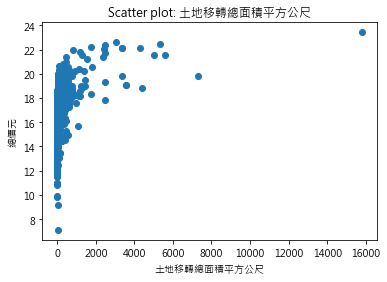

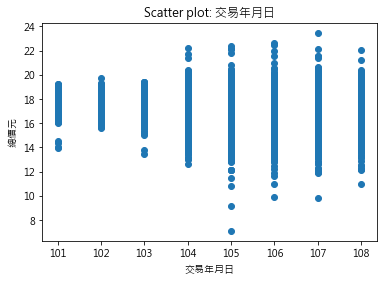

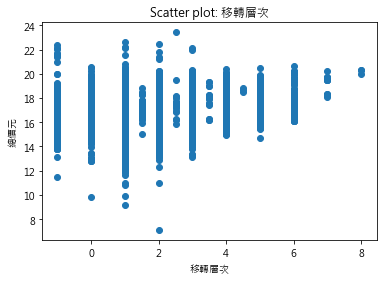

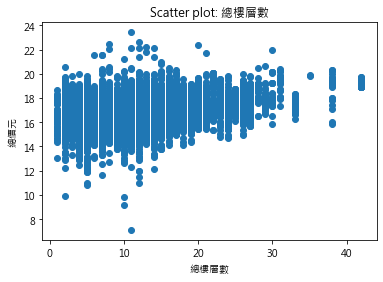

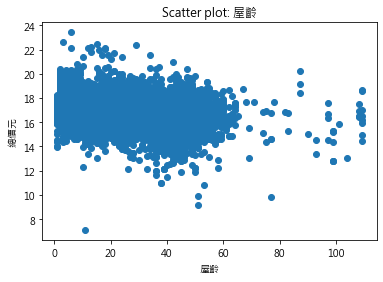

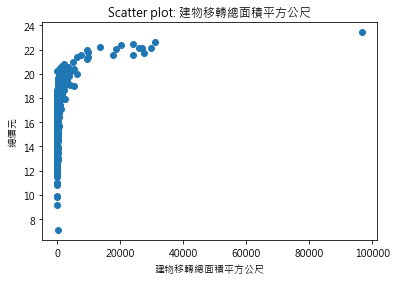

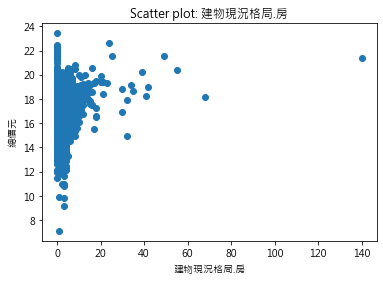

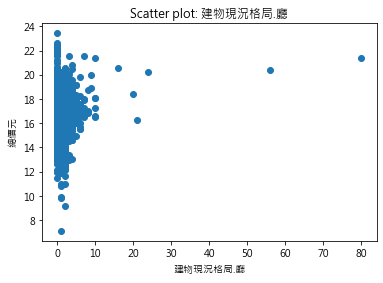

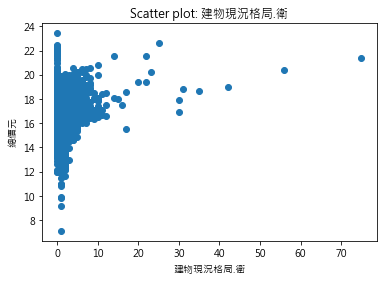

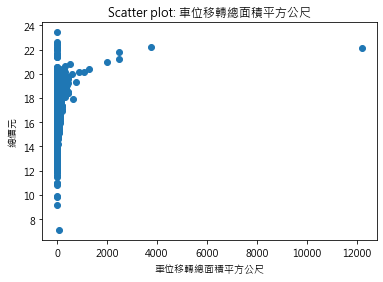

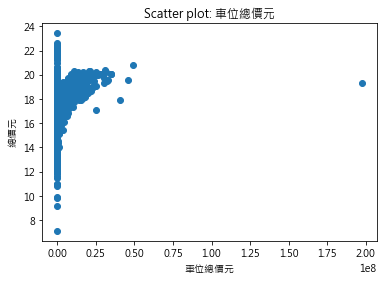

In [10]:
# draw scatter plots去看是否有異常
# 最後發現有一個離群值異常明顯

# 忽略警告訊息
%matplotlib inline
import warnings                             
warnings.filterwarnings('ignore')

# 顯示中文字
from matplotlib.font_manager import FontProperties

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
plot_lists = X_del.columns

def draw_scatter():
    for c in plot_lists:
        plt.scatter(data[c], np.log(data['總價元']))   # 要用log轉換
        plt.title('Scatter plot: ' + c)
        plt.xlabel(c)
        plt.ylabel('總價元')
        plt.show()
draw_scatter()

In [11]:
print(f'刪除異常值前 X.shape: {data.shape}')
data = data.loc[data['建物移轉總面積平方公尺'] < data['建物移轉總面積平方公尺'].mean()+3*data['建物移轉總面積平方公尺'].std()]
print(f'刪除異常值後 X.shape: {data.shape}')

刪除異常值前 X.shape: (57663, 61)
刪除異常值後 X.shape: (57613, 61)


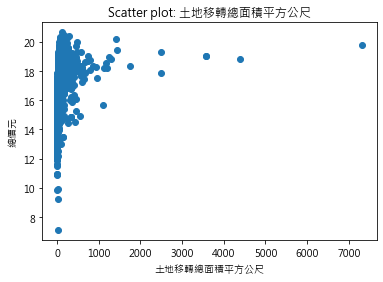

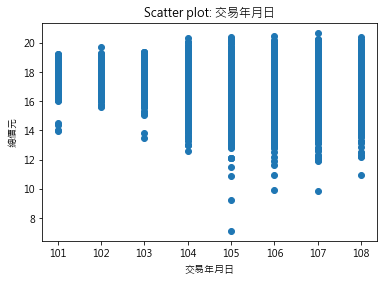

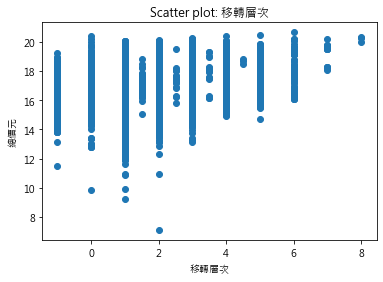

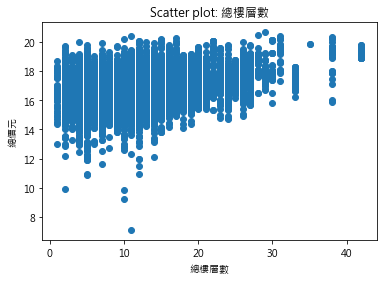

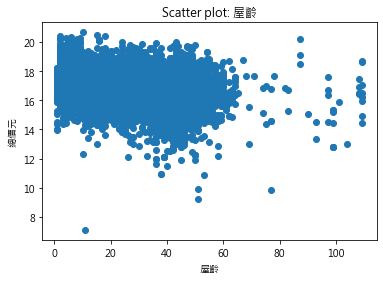

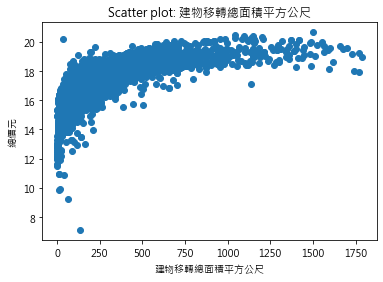

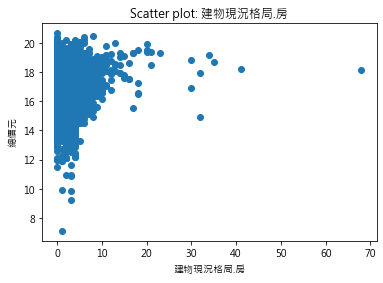

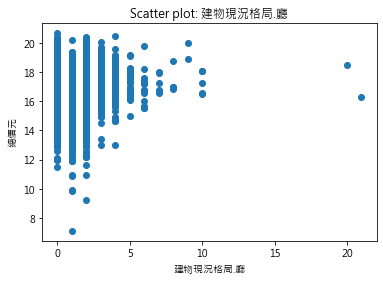

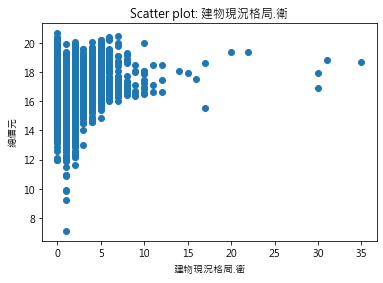

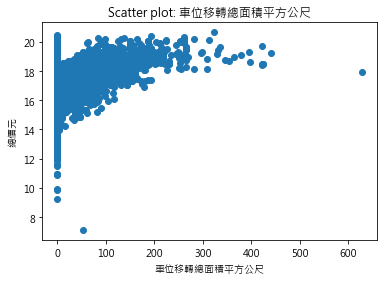

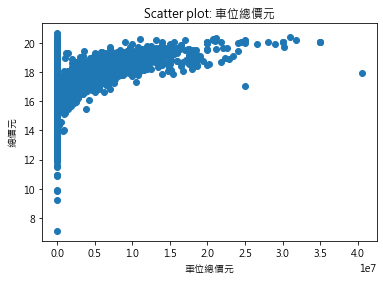

In [12]:
# 再畫一次, 異常值已經去除
draw_scatter()

In [13]:
# 真正分資料

# 這是完整檔案
y = pd.DataFrame(data['總價元'])  # 要改成總價
y = np.array(y).flatten()        # 把shape 修正正確
X = data.drop(columns=['總價元', '單價元平方公尺', '區總價'])   # 先不要加入區總價, 這是特徵工程的部分

# 這邊記得要開, 是因為關係數先把資料關起來了
# 行政區
# data = data.drop(columns=['總價元', '單價元平方公尺', '區總價'])
# 區總價
# data = data.drop(columns=['總價元', '單價元平方公尺', '士林區', '大同區', '大安區', '中山區', '中正區', '內湖區', '文山區', '北投區', '松山區', '信義區',
#        '南港區', '萬華區'])



In [14]:
# 將資料按照年份切分, 避免時間窺探
X_105 = X[np.where(X['交易年月日'] <= 105, True, False)]
X_106 = X[np.where(X['交易年月日'] <= 106, True, False)]
X_107 = X[np.where(X['交易年月日'] <= 107, True, False)]
X_108 = X[np.where(X['交易年月日'] <= 108, True, False)]

y_106 = y[np.where(X['交易年月日'] <= 106, True, False)]


X_107_only = X[np.where(X['交易年月日'] == 107, True, False)]
y_107_only = y[np.where(X['交易年月日'] == 107, True, False)]

print(X_108['交易年月日'].value_counts())

107    14997
106    14343
105    12932
108     7864
104     5392
103      909
102      798
101      378
Name: 交易年月日, dtype: int64


In [15]:
# 將模型評估融入scikit-learn方便之後觀察。
from sklearn.metrics import make_scorer
import numpy as np

def display_scores(scores):
    """
    模型評估分數的展示
    """
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

def hit_rate(y_pred, y_real, threshold=0.1):
    """
    模型評估, hit-rate
    """
    y_pred = np.array(y_pred)
    y_real = np.array(y_real)
    z = np.abs(y_pred - y_real) / y_real
    z = np.where(z <= threshold, 1, 0)

    return np.sum(z) / y_pred.shape[0]

# 建立自己的模型評估
hit_rate_scorer = make_scorer(hit_rate, greater_is_better = True)

In [16]:
# 訓練集與測試集
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 用6:2:2 訓練、驗證、測試
X_train, y_train = X_106.copy(), y_106
X_val, X_test, y_val, y_test = train_test_split(X_107_only, y_107_only, test_size=0.5, random_state=42, shuffle=True)

# 標準化
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)  
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

In [17]:
print(X_train.shape)
X_train

(34752, 58)


,士林區,大同區,大安區,中山區,中正區,內湖區,文山區,北投區,松山區,信義區,...,總樓層數,屋齡,建物移轉總面積平方公尺,建物現況格局.房,建物現況格局.廳,建物現況格局.衛,建物現況格局.隔間,有無管理組織,車位移轉總面積平方公尺,車位總價元
0,0,0,0,0,1,0,0,0,0,0,...,5,53,42,3,1,1,1,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,12,41,72,2,2,1,1,1,0,0
2,0,0,0,0,0,0,1,0,0,0,...,4,11,450,6,3,4,1,1,33,2800000
3,0,0,0,0,1,0,0,0,0,0,...,7,37,119,4,3,3,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,5,32,147,4,2,2,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,14,19,26,1,1,1,1,1,0,0
6,0,0,0,0,0,0,0,0,0,0,...,26,4,64,2,2,1,1,1,0,0
7,0,0,0,0,0,0,0,0,0,0,...,26,4,58,1,1,1,1,1,0,0
8,0,0,0,0,0,0,0,0,0,0,...,26,4,151,3,2,1,1,1,33,2700000
9,0,0,0,1,0,0,0,0,0,0,...,12,38,30,1,1,1,1,0,0,0


In [76]:
# 線性回歸model、決策樹、隨機森林
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings                             # 忽略警告
warnings.filterwarnings('ignore')

# 模型初始化, 先用默認參數
lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
svm = SVR()                    # 效果太差了
lasso = Lasso()
bayes = BayesianRidge()
mlpr = MLPRegressor()
gdbt = GradientBoostingRegressor()

# 裝在dict, 方便一次處理
# models = {'線性回歸': lr, '決策樹': dt, '隨機森林': rf, '支持向量機': svm}
models = {'線性回歸': lr, '決策樹': dt, '隨機森林': rf}
# models = {'Lasso': lasso, '貝氏回歸': bayes, 'MLPR': mlpr, 'GDBT': gdbt}

# 這是交叉驗證的方法, 因為時間因素無法直接用套件, 會產生時間窺探問題
# for name, model in models.items():
#     print(name)
#     scores = cross_val_score(model, X_train, y_train, scoring=hit_rate_scorer, cv=10)
#     display_scores(scores)
#     print()

# 模型訓練, 使用106前資料, 預測、驗證使用107資料, 確保沒有時間窺探
for name, model in models.items():
    print(name, "訓練中~~~")
    model.fit(X_train, y_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)
    print('驗證資料')
    print(f'{name} --- hit-rate(0.1): {hit_rate(y_pred_val, y_val, 0.1)}')
    print(f'{name} --- hit-rate(0.2): {hit_rate(y_pred_val, y_val, 0.2)}')
    print('測試資料')
    print(f'{name} --- hit-rate(0.1): {hit_rate(y_pred_test, y_test, 0.1)}')
    print(f'{name} --- hit-rate(0.2): {hit_rate(y_pred_test, y_test, 0.2)}')
    print()

線性回歸 訓練中~~~
驗證資料
線性回歸 --- hit-rate(0.1): 0.22646038943718325
線性回歸 --- hit-rate(0.2): 0.411176313683649
測試資料
線性回歸 --- hit-rate(0.1): 0.22176290172022936
線性回歸 --- hit-rate(0.2): 0.4137885051340179

決策樹 訓練中~~~
驗證資料
決策樹 --- hit-rate(0.1): 0.3692984795945585
決策樹 --- hit-rate(0.2): 0.5840224059749266
測試資料
決策樹 --- hit-rate(0.1): 0.36658221096146154
決策樹 --- hit-rate(0.2): 0.5782104280570742

隨機森林 訓練中~~~
驗證資料
隨機森林 --- hit-rate(0.1): 0.4314483862363297
隨機森林 --- hit-rate(0.2): 0.6968524939983995
測試資料
隨機森林 --- hit-rate(0.1): 0.4271236164821976
隨機森林 --- hit-rate(0.2): 0.6840912121616215



# 這是有時間窺探的, 全部下去跑

- 線性回歸
    - Scores: [0.23043573 0.24734446 0.2408411  0.24994581 0.24040754 0.24626057 0.22783438 0.23802298 0.23498808 0.24474312]
    - Mean: 0.24008237589421202
    - Standard deviation: 0.0069560285736230435

- 決策樹
    - Scores: [0.44894862 0.44743117 0.43637546 0.43355734 0.4430956  0.43680902 0.45393453 0.4389768  0.43615868 0.44699762]
    - Mean: 0.44222848471710385
    - Standard deviation: 0.006472939908939474

- 隨機森林
    - Scores: [0.49577282 0.4949057  0.48515066 0.46975938 0.49143724 0.4816822 0.49447214 0.48666811 0.4888359  0.48775201]
    - Mean: 0.4876436158681986
    - Standard deviation: 0.007374458570636914

- 支持向量機
    - Scores: [0.10925645 0.11034034 0.11229135 0.09841752 0.10687188 0.09928463 0.11055712 0.09798396 0.107739   0.11099068]
    - Mean: 0.1063732928679818
    - Standard deviation: 0.005328567845871182


# 這邊是使用106以前當訓練, 107當驗證、測試

## 有標準化
- 線性回歸 訓練中~~~
    - 驗證資料
        - 線性回歸 --- hit-rate(0.1): 0.0
        - 線性回歸 --- hit-rate(0.2): 0.0
    - 測試資料
        - 線性回歸 --- hit-rate(0.1): 0.0
        - 線性回歸 --- hit-rate(0.2): 0.0

- 決策樹 訓練中~~~
    - 驗證資料
        - 決策樹 --- hit-rate(0.1): 0.2402398401065956
        - 決策樹 --- hit-rate(0.2): 0.4241172551632245
    - 測試資料
        - 決策樹 --- hit-rate(0.1): 0.13830779480346436
        - 決策樹 --- hit-rate(0.2): 0.26115922718187873

- 隨機森林 訓練中~~~
    - 驗證資料
        - 隨機森林 --- hit-rate(0.1): 0.30406395736175884
        - 隨機森林 --- hit-rate(0.2): 0.5449700199866756
    - 測試資料
        - 隨機森林 --- hit-rate(0.1): 0.16842105263157894
        - 隨機森林 --- hit-rate(0.2): 0.31605596269153896

- Lasso 訓練中~~~
    - 驗證資料
        - Lasso --- hit-rate(0.1): 0.21385742838107927
        - Lasso --- hit-rate(0.2): 0.38454363757495
    - 測試資料
        - Lasso --- hit-rate(0.1): 0.15176548967355097
        - Lasso --- hit-rate(0.2): 0.29127248500999336

- 貝氏回歸 訓練中~~~
    - 驗證資料
        - 貝氏回歸 --- hit-rate(0.1): 0.08247834776815456
        - 貝氏回歸 --- hit-rate(0.2): 0.15789473684210525
    - 測試資料
        - 貝氏回歸 --- hit-rate(0.1): 0.08154563624250499
        - 貝氏回歸 --- hit-rate(0.2): 0.15949367088607594

- MLPR 訓練中~~~
    - 驗證資料
        - MLPR --- hit-rate(0.1): 0.0002664890073284477
        - MLPR --- hit-rate(0.2): 0.0002664890073284477
    - 測試資料
        - MLPR --- hit-rate(0.1): 0.00039973351099267156
        - MLPR --- hit-rate(0.2): 0.00039973351099267156


## 無標準化
- 線性回歸 訓練中~~~
    - 驗證資料
        - 線性回歸 --- hit-rate(0.1): 0.21998667554963358
        - 線性回歸 --- hit-rate(0.2): 0.4006662225183211
    - 測試資料
        - 線性回歸 --- hit-rate(0.1): 0.2099933377748168
        - 線性回歸 --- hit-rate(0.2): 0.3960026648900733

- 決策樹 訓練中~~~
    - 驗證資料
        - 決策樹 --- hit-rate(0.1): 0.37108594270486345
        - 決策樹 --- hit-rate(0.2): 0.5860093271152566
    - 測試資料
        - 決策樹 --- hit-rate(0.1): 0.3698867421718854
        - 決策樹 --- hit-rate(0.2): 0.5802798134576949

- 隨機森林 訓練中~~~
    - 驗證資料
        - 隨機森林 --- hit-rate(0.1): 0.4307794803464357
        - 隨機森林 --- hit-rate(0.2): 0.6852764823451033
    - 測試資料
        - 隨機森林 --- hit-rate(0.1): 0.43264490339773487
        - 隨機森林 --- hit-rate(0.2): 0.6874083944037308

- Lasso 訓練中~~~
    - 驗證資料
        - Lasso --- hit-rate(0.1): 0.21998667554963358
        - Lasso --- hit-rate(0.2): 0.4006662225183211
    - 測試資料
        - Lasso --- hit-rate(0.1): 0.20986009327115257
        - Lasso --- hit-rate(0.2): 0.3960026648900733

- 貝氏回歸 訓練中~~~
    - 驗證資料
        - 貝氏回歸 --- hit-rate(0.1): 0.22198534310459694
        - 貝氏回歸 --- hit-rate(0.2): 0.40346435709526984
    - 測試資料
        - 貝氏回歸 --- hit-rate(0.1): 0.21145902731512325
        - 貝氏回歸 --- hit-rate(0.2): 0.39880079946702196

- MLPR 訓練中~~~
    - 驗證資料
        - MLPR --- hit-rate(0.1): 0.03624250499666889
        - MLPR --- hit-rate(0.2): 0.07061958694203864
    - 測試資料
        - MLPR --- hit-rate(0.1): 0.03344437041972018
        - MLPR --- hit-rate(0.2): 0.06342438374417056
        
- GDBT 訓練中~~~
    - 驗證資料
        - GDBT --- hit-rate(0.1): 0.3300466355762825
        - GDBT --- hit-rate(0.2): 0.5834776815456363
    - 測試資料
        - GDBT --- hit-rate(0.1): 0.32858094603597604
        - GDBT --- hit-rate(0.2): 0.5804130579613591
        
        
### 最終得到隨機森林是最好的model

# 微調模型
- 微調模型超參數
- 嘗試集成學習, 組合多個好模型往往比單個模型來得好
    - 大多數模型太差, 不考慮
- 得到最終模型, 在測試集上測量性能

In [18]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV # GridSearchCV找最好超參數的值


param_grid = {'n_estimators': [3, 10, 30, 100, 200], 'max_features': [2, 4, 6, 8], 'max_depth': [1, 10, 100, 150]} #n_estimators:代表有幾棵樹
  
forest_reg = RandomForestRegressor(random_state=42, min_samples_leaf=2)  # estimator
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,                 # GridSearch 
                           scoring=hit_rate_scorer,
                           return_train_score=True)

In [78]:
# 開始網格搜尋最佳超參數
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=2,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [1, 10, 100, 150],
 

In [101]:
# 看結果
# print(grid_search.cv_results_)
best_params = grid_search.best_params_
# print(grid_search.best_score_)

#看各組的成績
cvres = grid_search.cv_results_
for hitRate, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(hitRate, params)

print(f'最佳超參數: {best_params}')

0.09392265193370165 {'max_depth': 1, 'max_features': 2, 'n_estimators': 3}
0.0916206261510129 {'max_depth': 1, 'max_features': 2, 'n_estimators': 10}
0.09570672191528545 {'max_depth': 1, 'max_features': 2, 'n_estimators': 30}
0.09484346224677716 {'max_depth': 1, 'max_features': 2, 'n_estimators': 100}
0.09521754143646409 {'max_depth': 1, 'max_features': 2, 'n_estimators': 200}
0.09665630755064457 {'max_depth': 1, 'max_features': 4, 'n_estimators': 3}
0.0979224217311234 {'max_depth': 1, 'max_features': 4, 'n_estimators': 10}
0.1009438305709024 {'max_depth': 1, 'max_features': 4, 'n_estimators': 30}
0.10235382136279926 {'max_depth': 1, 'max_features': 4, 'n_estimators': 100}
0.10292932780847146 {'max_depth': 1, 'max_features': 4, 'n_estimators': 200}
0.09723181399631677 {'max_depth': 1, 'max_features': 6, 'n_estimators': 3}
0.10344728360957643 {'max_depth': 1, 'max_features': 6, 'n_estimators': 10}
0.11026703499079189 {'max_depth': 1, 'max_features': 6, 'n_estimators': 30}
0.106929097605

In [19]:
# 重新build 隨機森林模型
randomForest = RandomForestRegressor(max_depth=100, max_features=8, n_estimators=200)
randomForest.fit(X_train, y_train)
y_pred_test = randomForest.predict(X_test)

print(f'hit-rate(0.1): {hit_rate(y_pred_test, y_test, 0.1)}')
print(f'hit-rate(0.2): {hit_rate(y_pred_test, y_test, 0.2)}')

hit-rate(0.1): 0.42525670089345247
hit-rate(0.2): 0.6860914788638485


### 原始參數
- hit-rate(0.1): 0.42371752165223187
- hit-rate(0.2): 0.6807461692205197

### GridSearch
- hit-rate(0.1): 0.42539005200693425
- hit-rate(0.2): 0.6839578610481397
- 可能搜尋得不夠多, 但花費時間已經很久了。
- 後續採用RandomSearch

In [108]:
# RandomSearch方法
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

# estimator
randomForest_random = RandomForestRegressor()

# 給定參數搜尋範圍，可以為list or distribuion
param_dist = {"n_estimators": [10, 100, 200],             # 給定list
              "max_depth": [3, 10, 100, 200],             # 給定list
              "max_features": sp_randint(1, 11),          # 給定distribution
              "min_samples_split": sp_randint(2, 11),     # 給定distribution
              "bootstrap": [True, False]                  # 給定list
              }

# 用RandomSearch+CV選取超参数
n_iter_search = 20
random_search = RandomizedSearchCV(randomForest_random, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, scoring=hit_rate_scorer)

In [109]:
# RandomSearch尋找超參數比較快, 訓練
random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [110]:
# 看結果
best_params_2 = random_search.best_params_

#看各組的成績
cvres_2 = random_search.cv_results_
for hitRate, params in zip(cvres_2["mean_test_score"], cvres_2["params"]):
    print(hitRate, params)

print(f'最佳超參數: {best_params_2}')

0.40339993520936385 {'bootstrap': False, 'max_depth': 200, 'max_features': 7, 'min_samples_split': 6, 'n_estimators': 200}
0.14643746513363326 {'bootstrap': False, 'max_depth': 3, 'max_features': 8, 'min_samples_split': 5, 'n_estimators': 10}
0.1100365911845405 {'bootstrap': False, 'max_depth': 3, 'max_features': 2, 'min_samples_split': 9, 'n_estimators': 10}
0.1531707895660166 {'bootstrap': True, 'max_depth': 10, 'max_features': 1, 'min_samples_split': 4, 'n_estimators': 10}
0.40515506179432803 {'bootstrap': False, 'max_depth': 100, 'max_features': 7, 'min_samples_split': 2, 'n_estimators': 200}
0.15409161147560158 {'bootstrap': False, 'max_depth': 3, 'max_features': 9, 'min_samples_split': 6, 'n_estimators': 200}
0.3236923831672685 {'bootstrap': True, 'max_depth': 100, 'max_features': 3, 'min_samples_split': 9, 'n_estimators': 200}
0.332583943721156 {'bootstrap': True, 'max_depth': 200, 'max_features': 3, 'min_samples_split': 6, 'n_estimators': 200}
0.34156209188885406 {'bootstrap': 

In [20]:
# 重新build隨機森林
# 結果更好了些, 但速度快得多, 也能探索更多超參數
randomForest_2 = RandomForestRegressor(bootstrap=True, max_depth=100, max_features=10, min_samples_split=3, n_estimators=200)
randomForest_2.fit(X_train, y_train)
y_pred_test = randomForest_2.predict(X_test)

print(f'hit-rate(0.1): {hit_rate(y_pred_test, y_test, 0.1)}')
print(f'hit-rate(0.2): {hit_rate(y_pred_test, y_test, 0.2)}')

hit-rate(0.1): 0.43285771436191495
hit-rate(0.2): 0.695026003467129


# 特徵工程
- 將建材重新納入考慮
    - 透過業內從業人員的建議, 原先過多的建材分類
        以鋼骨>鋼筋>加強磚造>磚造>其他來區分
- 房價指數
    - 透過經濟理論, 可能是一個重要特徵。
- 行政區改為區總價
    - 原本的o, 1二元特徵, 轉化為區總價亦可以保持區別, 特徵數也會得到減少
- 根據特徵重要性, 使不必要特徵減少, 增加效率(保有hit-rate的同時)

In [114]:
def fill_hp(data):
    hp = {
        '1080010': 281.66, '1080100': 284.13, '1081000': 280.45,
        '1070001': 279.76, '1070010': 278.04, '1070100': 275.93, '1071000': 276.3,
        '1060001': 267.73, '1060010': 271.57, '1060100': 273.97, '1061000': 274.44,
        '1050001': 270.97, '1050010': 269.52, '1050100': 276.76, '1051000': 271.36,
        '1040001': 273.98, '1040010': 286.22, '1040100': 289.6, '1041000': 302.06,
        '1030001': 294.26, '1030010': 297.45, '1030100': 310.2, '1031000': 298.5,
        '1020001': 304.85, '1020010': 294.89, '1020100': 292.94, '1021000': 284.55,
        '1010001': 269.15, '1010010': 268.28, '1010100': 262.7, '1011000': 254.19
    }
    return hp[data]

# 增加房價指數
data['HP'] = data['交易年月日'].astype(str) + data['Q1'].astype(str) + data['Q2'].astype(str) + data['Q3'].astype(str) + data['Q4'].astype(str)
data['HP'] = data['HP'].apply(fill_hp)


# 重新切分
X = data.drop(columns=['總價元', '單價元平方公尺', '區總價']) 

X_105 = X[np.where(X['交易年月日'] <= 105, True, False)]
X_106 = X[np.where(X['交易年月日'] <= 106, True, False)]
X_107 = X[np.where(X['交易年月日'] <= 107, True, False)]
X_108 = X[np.where(X['交易年月日'] <= 108, True, False)]

y_106 = y[np.where(X['交易年月日'] <= 106, True, False)]


X_107_only = X[np.where(X['交易年月日'] == 107, True, False)]
y_107_only = y[np.where(X['交易年月日'] == 107, True, False)]

X_train, y_train = X_106.copy(), y_106
X_val, X_test, y_val, y_test = train_test_split(X_107_only, y_107_only, test_size=0.5, random_state=42, shuffle=True)

In [116]:
# 重新訓練 model, 看成效如何
# 結果是下跌的, 故不採用

randomForest_2 = RandomForestRegressor(bootstrap=True, max_depth=100, max_features=10, min_samples_split=3, n_estimators=200)
randomForest_2.fit(X_train, y_train)
y_pred_test = randomForest_2.predict(X_test)

print(f'hit-rate(0.1): {hit_rate(y_pred_test, y_test, 0.1)}')
print(f'hit-rate(0.2): {hit_rate(y_pred_test, y_test, 0.2)}')

hit-rate(0.1): 0.41765568742499
hit-rate(0.2): 0.6830244032537671


In [120]:
# 換嘗試將行政區改成區總價
# 記得去除異常值

data = pd.read_csv('105-108data2.csv')   # 大部分前處理完的資料(剩下異常值偵測)
data = data.drop(columns=['士林區', '大同區', '大安區', '中山區', '中正區', '內湖區', '文山區', '北投區', '松山區', '信義區',
       '南港區', '萬華區'])
data = data.loc[data['建物移轉總面積平方公尺'] < data['建物移轉總面積平方公尺'].mean()+3*data['建物移轉總面積平方公尺'].std()]

In [121]:
# 重新切分
y = pd.DataFrame(data['總價元'])  # 要改成總價
y = np.array(y).flatten()        # 把shape 修正正確
X = data.drop(columns=['總價元', '單價元平方公尺']) 

X_105 = X[np.where(X['交易年月日'] <= 105, True, False)]
X_106 = X[np.where(X['交易年月日'] <= 106, True, False)]
X_107 = X[np.where(X['交易年月日'] <= 107, True, False)]
X_108 = X[np.where(X['交易年月日'] <= 108, True, False)]

y_106 = y[np.where(X['交易年月日'] <= 106, True, False)]


X_107_only = X[np.where(X['交易年月日'] == 107, True, False)]
y_107_only = y[np.where(X['交易年月日'] == 107, True, False)]

X_train, y_train = X_106.copy(), y_106
X_val, X_test, y_val, y_test = train_test_split(X_107_only, y_107_only, test_size=0.5, random_state=42, shuffle=True)

In [123]:
# 重新跑一次模型, 看成效如何
# hit-rate下降有點太多, 雖然訓練速度快速很多, 根據實際應用狀況決定是否採用。

randomForest_2 = RandomForestRegressor(bootstrap=True, max_depth=100, max_features=10, min_samples_split=3, n_estimators=200)
randomForest_2.fit(X_train, y_train)
y_pred_test = randomForest_2.predict(X_test)

print(f'hit-rate(0.1): {hit_rate(y_pred_test, y_test, 0.1)}')
print(f'hit-rate(0.2): {hit_rate(y_pred_test, y_test, 0.2)}')

hit-rate(0.1): 0.383384451260168
hit-rate(0.2): 0.6507534337911721


# 原始資料的相關性

## 熱力圖

In [21]:
# 相關係數

corr_matrix = data.corr()       # 直接得到相關係數的矩陣
target_corr = corr_matrix['總價元'].sort_values(ascending=False)   # 這個要有x有y的, 對總價元的相關係數, 大到小排列
target_corr

總價元                    1.000000
建物移轉總面積平方公尺            0.832569
車位總價元                  0.602717
車位移轉總面積平方公尺            0.574231
單價元平方公尺                0.460559
交易標的.房地.車位             0.362511
總樓層數                   0.346409
土地移轉總面積平方公尺            0.292069
建物型態.住宅大樓.11層含以上有電梯    0.259407
主要用途.停車空間              0.259407
區總價                    0.253928
移轉層次                   0.246688
有無管理組織                 0.146439
建物型態.辦公商業大樓            0.144435
主要用途.住家用               0.144435
建物現況格局.衛               0.125748
大安區                    0.100924
都市土地使用分區.其他            0.100524
建物現況格局.房               0.074311
建物型態.透天厝               0.059996
主要用途.見使用執照             0.059996
透天厝                    0.059996
中正區                    0.049287
信義區                    0.041448
見其他登記事項                0.041240
中山區                    0.031598
夾層                     0.027913
都市土地使用分區.工             0.025478
南港區                    0.017584
士林區                    0.017422
                         ...   
松山區     

Text(0.5, 1, '-top10 - 熱力圖')

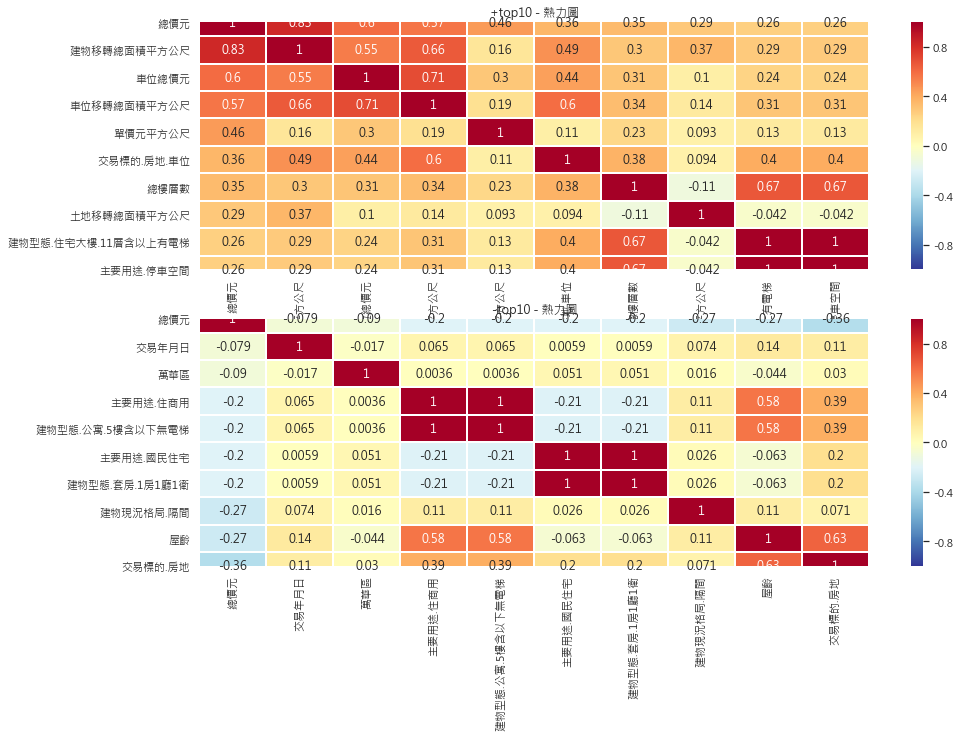

In [22]:
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import seaborn as sns # 另一個繪圖-樣式套件
plt.style.use('ggplot')

# 忽略警告訊息
%matplotlib inline
import warnings                             # 忽略警告
warnings.filterwarnings('ignore')

# 顯示中文字, note內有, 解決Python3那個
sns.set(font=['sans-serif'])
sns.set_style("whitegrid",{"font.sans-serif":['Microsoft JhengHei']})

plt.figure(figsize = (15, 10))            # 設定figsize, 很直觀
# 繪製相關係數 (correlations) 的 Heatmap
# note:
# cmap: colors, 有需要自己調色再去查, 不然不設定也是無所謂
# vmin: 顏色值的最小值
# vmax: 顏色值的最大值
# annot: 註釋資料
# f, (ax1,ax2) = plt.subplots(figsize = (18, 12),nrows=2)

# sns.heatmap(corr_matrix, cmap = plt.cm.RdYlBu_r, vmin = -1.0, annot = True, vmax = 1.0)
# plt.title('熱力圖')


# 只畫這些

negative_top_ten = list(target_corr[-9:].index)
negative_top_ten.insert(0, '總價元')

positive_top_ten = data[target_corr[:10].index]
negative_top_ten = data[negative_top_ten]

positive_top_ten_corr = positive_top_ten.corr()
negative_top_ten_corr = negative_top_ten.corr()

plt.subplot(211)
sns.heatmap(positive_top_ten_corr, cmap = plt.cm.RdYlBu_r, vmin = -1.0, annot = True, vmax = 1.0, linewidths=1)
plt.title('+top10 - 熱力圖')

plt.subplot(212)
sns.heatmap(negative_top_ten_corr, cmap = plt.cm.RdYlBu_r, vmin = -1.0, annot = True, vmax = 1.0, linewidths=1)
plt.title('-top10 - 熱力圖')
# positive_top_ten_corr

## 特徵重要性

In [23]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序

randomForest_2.feature_importances_   # 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表
feats = pd.Series(data=randomForest_2.feature_importances_, index=X.columns)
feats = feats.sort_values(ascending=False)
feats

建物移轉總面積平方公尺            0.341075
車位總價元                  0.121669
土地移轉總面積平方公尺            0.099625
車位移轉總面積平方公尺            0.094113
總樓層數                   0.047019
建物現況格局.衛               0.035814
屋齡                     0.027212
交易標的.房地.車位             0.021862
交易標的.房地                0.020490
建物現況格局.房               0.020162
移轉層次                   0.016462
建物現況格局.廳               0.012365
大安區                    0.010154
建物現況格局.隔間              0.009385
主要用途.停車空間              0.008359
建物型態.住宅大樓.11層含以上有電梯    0.007871
交易年月日                  0.007807
都市土地使用分區.其他            0.007731
信義區                    0.007641
中山區                    0.006165
內湖區                    0.005644
中正區                    0.005466
都市土地使用分區.住             0.005157
松山區                    0.005130
建物型態.套房.1房1廳1衛         0.003703
文山區                    0.003701
都市土地使用分區.商             0.003548
建物型態.辦公商業大樓            0.003488
北投區                    0.003465
主要用途.住家用               0.003372
主要用途.國民住宅              0.002896
有無管理組織  

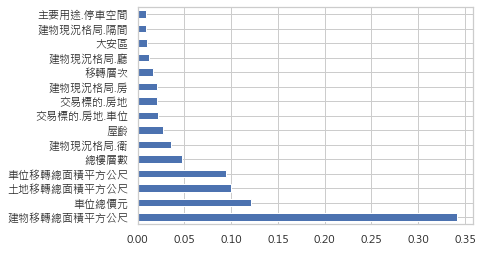

In [24]:
# 特徵重要性畫圖
feat_importances = feats.nlargest(15)
feat_importances.plot(kind='barh')

# 利用特徵重要性擷取新的特徵
- 然後再依此跑模型
- 檢驗效果是否差距巨大
    - 如果差距不多, 就可以減少計算量, 保有一定的準確度

In [25]:
# 特徵重要性大概多少%的選擇資料

def get_feature_percent(original_feats, percent):
    result = 0
    percent_columns = []
    for i, v in enumerate(original_feats):
        result += v
        percent_columns.append(original_feats.index[i])
        if result >= percent:
            break
    return percent_columns

percent_columns = get_feature_percent(feats, 0.90)

print(get_feature_percent(feats, 0.9))
# # 存成csv
# data[get_feature_percent(feats, 0.9)].to_csv('90%data_區總價_HP.csv')

['建物移轉總面積平方公尺', '車位總價元', '土地移轉總面積平方公尺', '車位移轉總面積平方公尺', '總樓層數', '建物現況格局.衛', '屋齡', '交易標的.房地.車位', '交易標的.房地', '建物現況格局.房', '移轉層次', '建物現況格局.廳', '大安區', '建物現況格局.隔間', '主要用途.停車空間', '建物型態.住宅大樓.11層含以上有電梯', '交易年月日']


In [27]:
# 根據特徵重要性擷取後, 重新測一下準確度是否改變太多
# 大約下降了4個百分點, 正常情況下, 不考慮。但節省許多運算資源

# 90%DATA
X_test = X_test[percent_columns]
X_train = X_train[percent_columns]

# model train and predict
rndf = RandomForestRegressor(bootstrap=True, max_depth=100, max_features=10, min_samples_split=3, n_estimators=200)
rndf.fit(X_train, y_train)

y_pred_test = rndf.predict(X_test)

print(hit_rate(y_pred_test, y_test, 0.1))
print(hit_rate(y_pred_test, y_test, 0.2))

0.4056540872116282
0.6606214161888252


# 啟動、監控和維護系統
- 監控系統效能
    - 透過設定hit-rate下降5%時提醒, 查看實際狀況。
- 評估輸入系統的資料品質
    - 這部分可以透過, 類似像box-plot或者是分布情形查看
- 定期用新的資料訓練
    - 同時也要保有彈性, 可以回溯之前的模型